# Analysis Code

In [132]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

# For  technical Indicators
import talib as ta

# For modelling and utilities
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from sklearn.metrics import make_scorer,f1_score,precision_score,classification_report,confusion_matrix
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn.preprocessing import StandardScaler
import graphviz
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier,plot_tree
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from matplotlib import pyplot
from sklearn.svm import SVC

#For utilities 
import time
import winsound

%matplotlib inline

In [2]:
#Read in the data from the current directory. The date of data ranges from 
SNP_data = pd.read_csv("SNP 500 data.csv",parse_dates=True,index_col= 'Date')

In [3]:
SNP_data.index

DatetimeIndex(['1943-01-04', '1943-01-05', '1943-01-06', '1943-01-07',
               '1943-01-08', '1943-01-11', '1943-01-12', '1943-01-13',
               '1943-01-14', '1943-01-15',
               ...
               '2020-03-16', '2020-03-17', '2020-03-18', '2020-03-19',
               '2020-03-20', '2020-03-23', '2020-03-24', '2020-03-25',
               '2020-03-26', '2020-03-27'],
              dtype='datetime64[ns]', name='Date', length=19421, freq=None)

In [4]:
SNP_data.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1943-01-04,9.92,9.92,9.92,9.92,9.92,0
1943-01-05,9.90,9.90,9.90,9.90,9.90,0
1943-01-06,9.89,9.89,9.89,9.89,9.89,0
1943-01-07,9.91,9.91,9.91,9.91,9.91,0
1943-01-08,9.92,9.92,9.92,9.92,9.92,0


In [5]:
SNP_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 19421 entries, 1943-01-04 to 2020-03-27
Data columns (total 6 columns):
Open         19421 non-null float64
High         19421 non-null float64
Low          19421 non-null float64
Close        19421 non-null float64
Adj Close    19421 non-null float64
Volume       19421 non-null int64
dtypes: float64(5), int64(1)
memory usage: 1.0 MB


In [6]:
#Filter 70 years data for now - becomes masterdata
# start_date = "1969-01-01"
# end_date = "2019-12-31"

start_date = "1950-01-01"
end_date = "2019-12-31"

SNP_data = SNP_data[start_date:end_date]


In [7]:
#Make a returns column
SNP_data[['1_day_return']] = SNP_data[['Adj Close']].pct_change() * 100

In [8]:
# We are using Adjusted Close instead of Close as its adjusted for stock splits/ share -buybacks etc
SNP_data = SNP_data.drop(['Close'], axis=1)

In [9]:
#For the sake of clarity, renaming Adj Close to Close
SNP_data.columns = SNP_data.columns.str.replace('Adj Close', 'Close')

In [10]:
SNP_data.describe()

,Open,High,Low,Close,Volume,1_day_return
count,17613.000000,17613.000000,17613.000000,17613.000000,1.761300e+04,17612.000000
mean,602.189355,605.676118,598.493530,602.321780,9.582886e+08,0.034546
std,727.082742,730.631133,723.220135,727.195771,1.569436e+09,0.960247
min,16.660000,16.660000,16.660000,16.660000,6.800000e+05,-20.466931
25%,86.370003,87.099998,85.690002,86.379997,9.170000e+06,-0.401151
50%,175.479996,177.300003,175.149994,176.529999,1.008500e+08,0.047659
75%,1113.859985,1120.270020,1106.420044,1113.859985,1.294900e+09,0.496257
max,3247.229980,3247.929932,3234.370117,3240.020020,1.145623e+10,11.580037


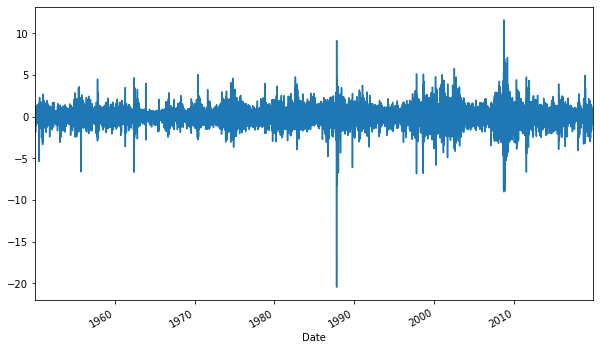

In [11]:
#Free view of daily returns
SNP_data['1_day_return'].plot(kind = 'line',figsize = (10,6))

C:\Users\lenovo\Anaconda3\lib\site-packages\numpy\lib\histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\lenovo\Anaconda3\lib\site-packages\numpy\lib\histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


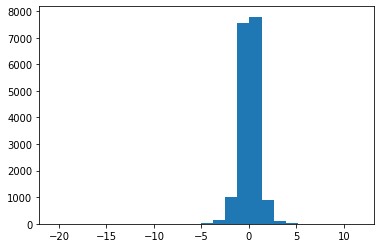

In [12]:
#Let's look at the histogram/distribution pattern of returns
plt.hist(SNP_data['1_day_return'],bins = 25)
plt.show()

In [13]:
#And in which range do most of the data lie?
pd.cut(SNP_data['1_day_return'], bins=25).value_counts().sort_index()

(-20.499, -19.185]       1
(-19.185, -17.903]       0
(-17.903, -16.621]       0
(-16.621, -15.339]       0
(-15.339, -14.058]       0
(-14.058, -12.776]       0
(-12.776, -11.494]       0
(-11.494, -10.212]       0
(-10.212, -8.93]         1
(-8.93, -7.648]          3
(-7.648, -6.366]         8
(-6.366, -5.084]        10
(-5.084, -3.803]        29
(-3.803, -2.521]       139
(-2.521, -1.239]      1014
(-1.239, 0.0431]      7548
(0.0431, 1.325]       7792
(1.325, 2.607]         906
(2.607, 3.889]         107
(3.889, 5.171]          42
(5.171, 6.453]           6
(6.453, 7.734]           3
(7.734, 9.016]           0
(9.016, 10.298]          1
(10.298, 11.58]          2
Name: 1_day_return, dtype: int64

##Seems like most of the returns are in ~1.23 to 1.325..ish. 

In [14]:
## Lets see other properties of index returns

print("Mean of daily return : %.4f"%(SNP_data['1_day_return'].mean()))
print("Median of daily return : %.4f"%(SNP_data['1_day_return'].median()))
print("Standard Deviation of daily return : %.4f"%(SNP_data['1_day_return'].std()))
print("Kurtosis of daily return : %.4f"%(SNP_data['1_day_return'].kurtosis()))
print("Skewness of daily return : %.4f"%(SNP_data['1_day_return'].skew()))

Mean of daily return : 0.0345
Median of daily return : 0.0477
Standard Deviation of daily return : 0.9602
Kurtosis of daily return : 20.5865
Skewness of daily return : -0.6416


##So this seems to be approximately a Leptokurtic negatively skewed distribution

##Let's have a look at the price graph properties,adding Technical analysis as well

In [15]:
#Trend Indicator
SNP_data['SMA_5'] = ta.SMA(SNP_data['Close'],timeperiod = 5)

In [16]:
#Trend Indicator
SNP_data['SMA_20'] = ta.SMA(SNP_data['Close'],timeperiod = 20)

In [17]:
#This will be used to determine trend reversal
SNP_data['SMA_diff_5_20'] = SNP_data['SMA_5'] - SNP_data['SMA_20']

In [18]:
'''
Defining Price_trend as a feature which is :
1 i.e Long if the SMA_5 crosses SMA_20 from below
-1 i.e Short if the SMA_5 crosses SMA_20 from above
0 otherwise
'''

'\nDefining Price_trend as a feature which is :\n1 i.e Long if the SMA_5 crosses SMA_20 from below\n-1 i.e Short if the SMA_5 crosses SMA_20 from above\n0 otherwise\n'

In [19]:
SNP_data.dropna(axis = 0,inplace = True)
col_pos = SNP_data.columns.get_loc('SMA_diff_5_20')
SNP_data['Price_trend'] = 0
col_trend = SNP_data.columns.get_loc('Price_trend')

for ctr in range(3,len(SNP_data)):
    signal_long = ((SNP_data.iloc[ctr,col_pos]>0) & (SNP_data.iloc[ctr-1,col_pos]<0) & (SNP_data.iloc[ctr-2,col_pos]<0) & (SNP_data.iloc[ctr-3,col_pos]<0))   
    if signal_long:
        SNP_data.iloc[ctr,col_trend] = 1
    signal_short = ((SNP_data.iloc[ctr,col_pos]<0) & (SNP_data.iloc[ctr-1,col_pos]>0) & (SNP_data.iloc[ctr-2,col_pos]>0) & (SNP_data.iloc[ctr-3,col_pos]>0))
    if signal_short:
        SNP_data.iloc[ctr,col_trend] = -1

In [20]:
#Momentum indcator
SNP_data['RSI'] = ta.RSI(SNP_data['Close'],timeperiod = 14)

In [21]:
#Trend indicator
SNP_data['ADX'] = ta.ADX(SNP_data['High'], SNP_data['Low'], SNP_data['Close'], timeperiod=14)

In [22]:
#Volatility Indicator
SNP_data['BB_UP'], SNP_data['BB_MID'], SNP_data['BB_LOW'] = ta.BBANDS(SNP_data['Close'], timeperiod=14, nbdevup=2, nbdevdn=2, matype=0)
SNP_data['BB_UP_MID'] = (SNP_data['BB_UP']-SNP_data['BB_MID'])/SNP_data['BB_MID']
SNP_data['BB_LOW_MID'] = (SNP_data['BB_LOW']-SNP_data['BB_MID'])/SNP_data['BB_MID']

In [23]:
#Trend indicator
SNP_data['SAR'] = ta.SAR(SNP_data['High'], SNP_data['Low'], acceleration=0.02, maximum=0.2)

In [24]:
#Removing the NAs produced
SNP_data.dropna(axis = 0,inplace = True)

In [25]:
SNP_data.head()

,Open,High,Low,Close,Volume,1_day_return,SMA_5,SMA_20,SMA_diff_5_20,Price_trend,RSI,ADX,BB_UP,BB_MID,BB_LOW,BB_UP_MID,BB_LOW_MID,SAR
Date,,,,,,,,,,,,,,,,,,
1950-03-10,17.090000,17.090000,17.090000,17.090000,1260000,0.117165,17.174000,17.1885,-0.0145,-1,46.662090,16.631088,17.350603,17.213572,17.076540,0.007961,-0.007961,17.315000
1950-03-13,17.120001,17.120001,17.120001,17.120001,1060000,0.175547,17.134001,17.1805,-0.0465,0,48.761090,15.657589,17.353102,17.207857,17.062613,0.008441,-0.008441,17.310100
1950-03-14,17.250000,17.250000,17.250000,17.250000,1140000,0.759340,17.144000,17.1810,-0.0370,0,56.710702,15.496796,17.358704,17.213572,17.068440,0.008431,-0.008431,17.305298
1950-03-15,17.450001,17.450001,17.450001,17.450001,1830000,1.159426,17.196000,17.2005,-0.0045,0,65.562873,16.639104,17.420069,17.230715,17.041360,0.010989,-0.010989,17.070000
1950-03-16,17.490000,17.490000,17.490000,17.490000,2060000,0.229221,17.280000,17.2220,0.0580,1,67.015585,17.910440,17.476949,17.245715,17.014480,0.013408,-0.013408,17.077600


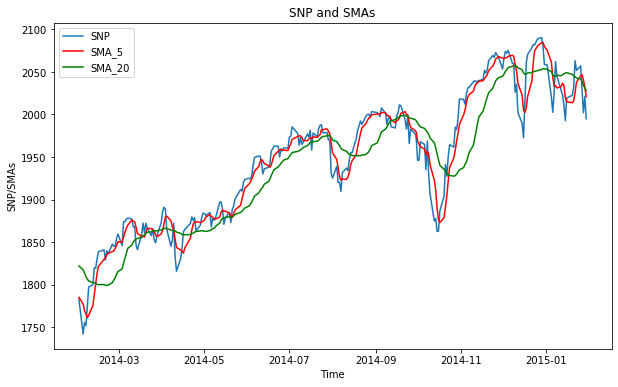

In [130]:
#Let's visualize the data
plot_data = SNP_data["2014-01-31":"2015-01-31"]
fig, ax  = plt.subplots(figsize = (10,6))
ax.set_title('SNP and SMAs')
a = ax.plot(plot_data.index,plot_data['Close'],label='SNP')
ax.set_xlabel('Time')
ax.set_ylabel('SNP/SMAs')


b = ax.plot(plot_data.index,plot_data['SMA_5'],'r-',label='SMA_5')
c = ax.plot(plot_data.index,plot_data['SMA_20'],'g-',label='SMA_20')


plots = a+b+c
labs = [l.get_label() for l in plots]
ax.legend(plots, labs, loc=0)


plt.show()

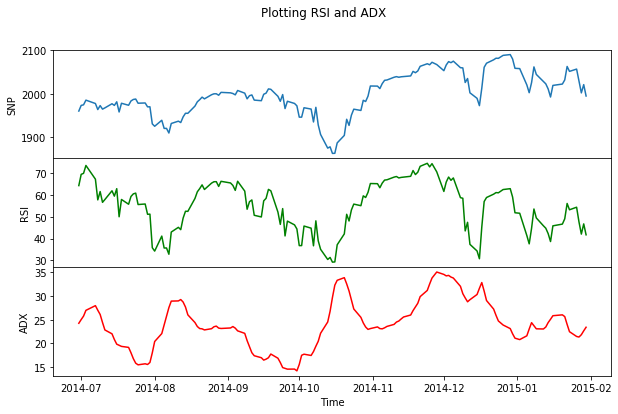

In [27]:
#Let's Have a look at Momentum Indicators
plot_data = SNP_data["2014-06-30":"2015-01-31"]
fig, axs = plt.subplots(3, sharex=True, gridspec_kw={'hspace': 0},figsize = (10,6))
fig.suptitle('Plotting RSI and ADX')
axs[0].plot(plot_data.index, plot_data['Close'])
axs[0].set_ylabel('SNP')

axs[1].plot(plot_data.index, plot_data['RSI'],'g-')
axs[1].set_ylabel('RSI')

axs[2].plot(plot_data.index, plot_data['ADX'], 'r-')
axs[2].set_ylabel('ADX')
axs[2].set_xlabel('Time')

# Hide x labels and tick labels for all but bottom plot.
for ax in axs:
    ax.label_outer()

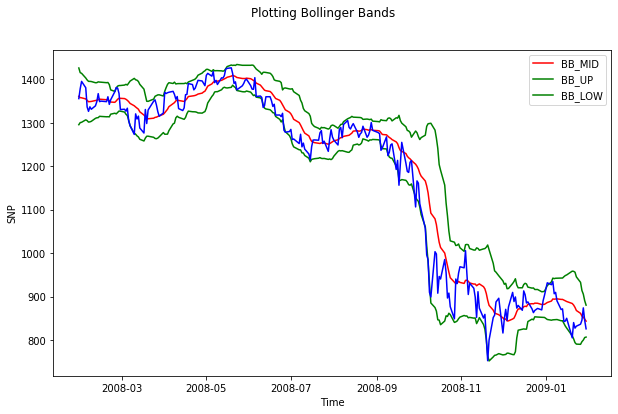

In [28]:
# How are bollinger bands behaving?
plot_data = SNP_data["2008-01-30":"2009-01-31"]
fig, ax  = plt.subplots(figsize = (10,6))
fig.suptitle('Plotting Bollinger Bands')
a = ax.plot(plot_data.index,plot_data['BB_MID'],'r-',label='BB_MID')
ax.set_xlabel('Time')
ax.set_ylabel('SNP')


b = ax.plot(plot_data.index,plot_data['BB_UP'],'g-',label='BB_UP')


c = ax.plot(plot_data.index,plot_data['BB_LOW'],'g-',label='BB_LOW')

d = ax.plot(plot_data.index,plot_data['Close'],'b-',label='SNP')

plots = a+b+c
labs = [l.get_label() for l in plots]
ax.legend(plots, labs, loc=0)


plt.show()

## Notice that whenever the price touches lower Bollinger Band, it bounces back up . This is a god indicator,but good for a very short time frame. It can be used for confirmation though

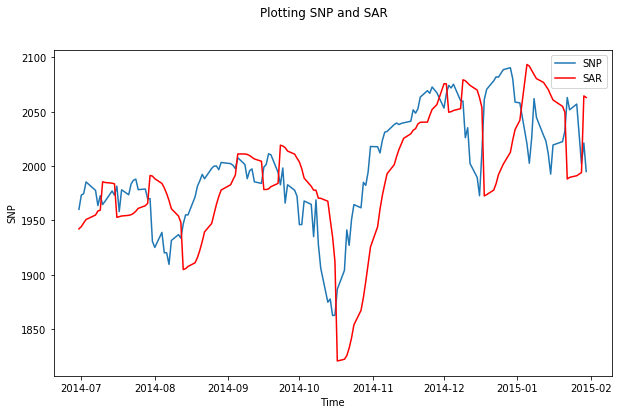

In [131]:
#Let's see how SARS are behaving
plot_data = SNP_data["2014-06-30":"2015-01-31"]
fig, ax  = plt.subplots(figsize = (10,6))
fig.suptitle('Plotting SNP and SAR')
a = ax.plot(plot_data.index,plot_data['Close'],label = 'SNP')
ax.set_xlabel('Time')
ax.set_ylabel('SNP')

b = ax.plot(plot_data.index,plot_data['SAR'],'r-',label = 'SAR')

plots = a+b
labs = [l.get_label() for l in plots]
ax.legend(plots, labs, loc=0)


plt.show()

## If we observe the graph we can notice that Prabolic SAR has a very hypermetropic ability to predit, which will lead to too much noise.  Hence, we drop this for our Trend prediction

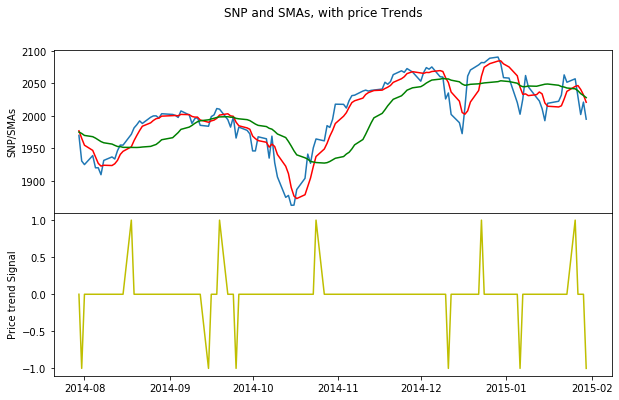

In [30]:
#Let's magnify the data a bit, and analyse further

plot_data = SNP_data["2014-07-30":"2015-01-31"]
fig, axs = plt.subplots(2, sharex=True, gridspec_kw={'hspace': 0},figsize = (10,6))
fig.suptitle('SNP and SMAs, with price Trends')
axs[0].plot(plot_data.index, plot_data['Close'])
axs[0].plot(plot_data.index,plot_data['SMA_5'],'r-')
axs[0].plot(plot_data.index,plot_data['SMA_20'],'g-')
axs[0].set_ylabel('SNP/SMAs')

axs[1].plot(plot_data.index, plot_data['Price_trend'],'y-')
axs[1].set_ylabel('Price trend Signal')

# Hide x labels and tick labels for all but bottom plot.
for ax in axs:
    ax.label_outer()

plt.show()

## Notice that the time lag between the trend reversal signal and the lowest point of trend is not constant. It can be between 3-9 days depending upon how volatile the Closing Price is. So we introduce a new feature here: 
##  We take the properties of indicator features which most likely lead to trend reversals. For this, we take max/min of indicator values in last 10 days whenever a trend reverses. Also, replace the last 10 day data with these features, and let the rest of data remain as it is.

## This leads to Price trends and the feature data whichmost likely lead to trend reversal.

## Also, this form data preprocessing will lead to data refining and remove the ambigious signals


In [31]:
def add_rolling_feature(data,start_date,end_date):
    data = data.loc[start_date:end_date]
    data.dropna(axis = 0,inplace = True)
    data.reset_index(inplace = True,drop=True)


    #Rolling Strategy
    new_cols = ['Volume','RSI','ADX','BB_UP_MID','BB_LOW_MID']
    for ctr in new_cols:
        data[ctr+'_Rolling_10_max'] = data[ctr].rolling(10).max() 
        data[ctr+'_Rolling_10_min'] = data[ctr].rolling(10).min() 
        data[ctr+'_Rolling_10'] = 0

    data.dropna(axis = 0,inplace = True)
    data.reset_index(inplace = True,drop=True)


    i = data.shape[0]-1

    while i>=0 :
        if data.loc[i,'Price_trend'] == 1:
            data.loc[i,'Volume_Rolling_10'] = data.loc[i,'Volume_Rolling_10_max']
            data.loc[i,'RSI_Rolling_10'] = data.loc[i,'RSI_Rolling_10_min']
            data.loc[i,'ADX_Rolling_10'] = data.loc[i,'ADX_Rolling_10_max']
            data.loc[i,'BB_UP_MID_Rolling_10'] = data.loc[i,'BB_UP_MID_Rolling_10_min']
            data.loc[i,'BB_LOW_MID_Rolling_10'] = data.loc[i,'BB_LOW_MID']
            if (i-10) >= -1:
                data.drop(range(i-1,i-10,-1),inplace = True)
                i = i-10
            else:
                data.drop(range(i-1,-1,-1),inplace = True)
                i = -1
        elif data.loc[i,'Price_trend'] == -1:
            data.loc[i,'Volume_Rolling_10'] = data.loc[i,'Volume_Rolling_10_max']
            data.loc[i,'RSI_Rolling_10'] = data.loc[i,'RSI_Rolling_10_max']
            data.loc[i,'ADX_Rolling_10'] = data.loc[i,'ADX_Rolling_10_max']
            data.loc[i,'BB_UP_MID_Rolling_10'] = data.loc[i,'BB_UP_MID']
            data.loc[i,'BB_LOW_MID_Rolling_10'] = data.loc[i,'BB_LOW_MID_Rolling_10_max']
            if (i-10) >= -1:
                data.drop(range(i-1,i-10,-1),inplace = True)
                i = i-10
            else:
                data.drop(range(i-1,-1,-1),inplace = True)
                i = -1
        else :
            data.loc[i,'Volume_Rolling_10'] = data.loc[i,'Volume']
            data.loc[i,'RSI_Rolling_10'] = data.loc[i,'RSI']
            data.loc[i,'ADX_Rolling_10'] = data.loc[i,'ADX']
            data.loc[i,'BB_UP_MID_Rolling_10'] = data.loc[i,'BB_UP_MID']
            data.loc[i,'BB_LOW_MID_Rolling_10'] = data.loc[i,'BB_LOW_MID']
            i = i-1


    data = data[['Price_trend','Volume_Rolling_10','RSI_Rolling_10', 'ADX_Rolling_10', 'BB_UP_MID_Rolling_10','BB_LOW_MID_Rolling_10']]
    data.dropna(axis = 0,inplace = True)
    data.reset_index(inplace = True,drop=True)
    return data

In [134]:
SNP_data_preprocessed = add_rolling_feature(SNP_data,"1990-01-01","2019-12-31")

C:\Users\lenovo\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\lenovo\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
C:\Users\lenovo\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = valu

In [33]:
SNP_data_preprocessed = SNP_data_preprocessed[['Price_trend','Volume_Rolling_10','RSI_Rolling_10', 'ADX_Rolling_10', 'BB_UP_MID_Rolling_10','BB_LOW_MID_Rolling_10']]

In [33]:
#Final check to see if there are NAs.
SNP_data_preprocessed.dropna(axis = 0,inplace = True)
SNP_data_preprocessed.head()

,Price_trend,Volume_Rolling_10,RSI_Rolling_10,ADX_Rolling_10,BB_UP_MID_Rolling_10,BB_LOW_MID_Rolling_10
0,0,140590000.0,34.717985,17.430099,0.034983,-0.034983
1,0,186070000.0,40.908558,19.310784,0.037434,-0.037434
2,0,170470000.0,37.488494,20.689073,0.041719,-0.041719
3,0,178590000.0,38.788143,22.255217,0.044574,-0.044574
4,0,185590000.0,40.409447,23.089922,0.045628,-0.045628


In [35]:
print(SNP_data_preprocessed.shape)
print(SNP_data_preprocessed['Price_trend'].value_counts())

(4787, 6)
 0    4480
 1     171
-1     136
Name: Price_trend, dtype: int64


## Notice that the classes are heavily imbalanced, so we have to introduce weights during model fits or modify our paramaters as required in our modeling

In [37]:
# Splitting and retreiving the weights


X_train, X_test, y_train, y_test = train_test_split(SNP_data_preprocessed.loc[:,'Volume_Rolling_10':'BB_LOW_MID_Rolling_10'],
                                                    SNP_data_preprocessed.loc[:,'Price_trend'], 
                                                    test_size = 0.3, random_state=42,
                                                    stratify = SNP_data_preprocessed.loc[:,'Price_trend'])

In [139]:

# Computing Class weights to pass as a sample weight array to models

class_weights = list(class_weight.compute_class_weight('balanced',np.unique(y_train),y_train))

w_array = np.ones(y_train.shape[0], dtype = 'float')
for i, val in enumerate((y_train)):
    w_array[i] = class_weights[int(val)+1]

print(np.unique(y_train))
print(class_weights)

[-1  0  1]
[11.75438596491228, 0.35619351408825095, 9.305555555555555]


# Now we will fit our  data to our models

# SVM Classifier

In [39]:

from sklearn.model_selection import train_test_split

#SVM needs scaled data as input, scaling data for model
#Splittting the data, adding stratify =True as well
scaler = StandardScaler()

X_scaled = scaler.fit_transform(SNP_data_preprocessed.loc[:,'Volume_Rolling_10':'BB_LOW_MID_Rolling_10'])


X_train, X_test, y_train, y_test = train_test_split(X_scaled,
                                                    SNP_data_preprocessed.loc[:,'Price_trend'], 
                                                    test_size = 0.3, random_state=42,
                                                    stratify = SNP_data_preprocessed.loc[:,'Price_trend'])


# Also,Let's have a peek at their Correlations
X_train_scaleddf = pd.DataFrame(data=X_train, index = y_train.index, columns=SNP_data_preprocessed.columns[1:])

SNP_data_scaleddf = pd.concat([X_train_scaleddf, y_train], axis=1)


print(SNP_data_scaleddf.corr())

print(SNP_data_scaleddf.describe())



                       Volume_Rolling_10  RSI_Rolling_10  ADX_Rolling_10  \
Volume_Rolling_10               1.000000       -0.084531       -0.024880   
RSI_Rolling_10                 -0.084531        1.000000        0.094217   
ADX_Rolling_10                 -0.024880        0.094217        1.000000   
BB_UP_MID_Rolling_10            0.218549       -0.267722        0.272266   
BB_LOW_MID_Rolling_10          -0.220422        0.285112       -0.271610   
Price_trend                     0.016857       -0.260208        0.010354   

                       BB_UP_MID_Rolling_10  BB_LOW_MID_Rolling_10  \
Volume_Rolling_10                  0.218549              -0.220422   
RSI_Rolling_10                    -0.267722               0.285112   
ADX_Rolling_10                     0.272266              -0.271610   
BB_UP_MID_Rolling_10               1.000000              -0.995748   
BB_LOW_MID_Rolling_10             -0.995748               1.000000   
Price_trend                       -0.026533    

In [43]:
'''Here, note that we are making a custom scorer here. We want to focus on the accuracy of the predictions,
so we evaluate the hyperparameters on the basis of their micro f_1score of labels -1 and 1 because we care more about the positive labels'''

my_scorer = make_scorer(f1_score,average="micro",labels = [-1,1],greater_is_better=True )


param_grid= {'kernel':('linear', 'rbf','poly'),'C' : [0.1,1,10,100]}


grid_searcher = GridSearchCV( SVC(),param_grid,scoring=my_scorer,cv = 5,n_jobs = -1,verbose = 5 )



In [44]:
# Fitting the classifier on data


t0 = time.time()

gridsearch_fit = grid_searcher.fit(X_train,y_train,sample_weight = w_array)

print("SVM fitted in %d seconds" %(time.time() - t0))

#Just to give us a notification when the tuning finishes
duration = 1500  # milliseconds
freq = 240  # Hz
winsound.Beep(freq, duration)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    5.8s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  3.5min finished


SVM fitted in 424 seconds


In [47]:
print("# Tuned hyper-parameters for micro f1_score")
print("Best parameters set found on development set: \n")
print(gridsearch_fit.best_params_)
print("With micro f1_score : %.4f \n" %(gridsearch_fit.best_score_))
print("Grid scores on development set:")
print()

means = gridsearch_fit.cv_results_['mean_test_score']
stds = gridsearch_fit.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, gridsearch_fit.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
          % (mean, std * 2, params))
print()

# Tuned hyper-parameters for micro f1_score
Best parameters set found on development set: 

{'C': 100, 'kernel': 'linear'}
With micro f1_score : 0.6284 

Grid scores on development set:

0.246 (+/-0.032) for {'C': 0.1, 'kernel': 'linear'}
0.190 (+/-0.015) for {'C': 0.1, 'kernel': 'rbf'}
0.250 (+/-0.067) for {'C': 0.1, 'kernel': 'poly'}
0.468 (+/-0.052) for {'C': 1, 'kernel': 'linear'}
0.279 (+/-0.021) for {'C': 1, 'kernel': 'rbf'}
0.323 (+/-0.046) for {'C': 1, 'kernel': 'poly'}
0.543 (+/-0.064) for {'C': 10, 'kernel': 'linear'}
0.339 (+/-0.088) for {'C': 10, 'kernel': 'rbf'}
0.410 (+/-0.079) for {'C': 10, 'kernel': 'poly'}
0.628 (+/-0.065) for {'C': 100, 'kernel': 'linear'}
0.388 (+/-0.033) for {'C': 100, 'kernel': 'rbf'}
0.508 (+/-0.128) for {'C': 100, 'kernel': 'poly'}



In [51]:
## Test Evaluation results on best parameter

y_pred = pd.DataFrame(gridsearch_fit.predict(X_test))
print(confusion_matrix(y_test,y_pred))
print("\n Precision Score of positive labels: %.4f \n"%(precision_score(y_test,y_pred,average='micro', labels = [-1,1])))
print(classification_report(y_test, y_pred, digits=12))

[[  35    6    0]
 [   0 1256   89]
 [   0    4   47]]

 Precision Score of positive labels: 0.4795 

              precision    recall  f1-score   support

          -1  1.000000000000 0.853658536585 0.921052631579        41
           0  0.992101105845 0.933828996283 0.962083492915      1345
           1  0.345588235294 0.921568627451 0.502673796791        51

    accuracy                      0.931106471816      1437
   macro avg  0.779229780380 0.903018720106 0.795269973762      1437
weighted avg  0.969381341240 0.931106471816 0.944608085944      1437



##SVM gave pretty good results. Let's check what output is generated by other models

# KNN

In [52]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

scaler = StandardScaler()

X_scaled = scaler.fit_transform(SNP_data_preprocessed.loc[:,'Volume_Rolling_10':'BB_LOW_MID_Rolling_10'])


X_train, X_test, y_train, y_test = train_test_split(X_scaled,
                                                    SNP_data_preprocessed.loc[:,'Price_trend'], 
                                                    test_size = 0.3, random_state=42,
                                                    stratify = SNP_data_preprocessed.loc[:,'Price_trend'])




In [56]:
#Hyperparameter tuning KNN Classification 

params = {'n_neighbors':[2,3,4,5, 6, 7, 8, 9,10],'leaf_size':[1,2,3,5],
          'weights': ['distance', 'uniform'], 'p':[2, 3],
         'algorithm':['auto', 'ball_tree','kd_tree','brute']}



my_scorer = make_scorer(f1_score,average="micro",labels = [-1,1],greater_is_better=True )


grid_searcher = GridSearchCV(KNeighborsClassifier(), scoring = my_scorer,cv = 5, param_grid = params, n_jobs = 4,verbose = 2)



In [57]:

t0 = time.time()
grid_searchfit = grid_searcher.fit(X_train,y_train)
# KNN doesn't has sampleweighting feature, which is a big bummer


print("KNN fitted in %d seconds" %(time.time() - t0))


duration = 1500  # milliseconds
freq = 240  # Hz
winsound.Beep(freq, duration)

Fitting 5 folds for each of 576 candidates, totalling 2880 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    4.9s
[Parallel(n_jobs=4)]: Done 727 tasks      | elapsed:   14.0s
[Parallel(n_jobs=4)]: Done 1390 tasks      | elapsed:   43.3s
[Parallel(n_jobs=4)]: Done 2217 tasks      | elapsed:  1.1min
[Parallel(n_jobs=4)]: Done 2582 tasks      | elapsed:  2.0min
[Parallel(n_jobs=4)]: Done 2880 out of 2880 | elapsed:  2.6min finished


KNN fitted in 156 seconds


In [59]:
print("# Tuned hyper-parameters for micro f1_score")
print("Best parameters set found on development set: \n")
print(grid_searchfit.best_params_)
print("With micro f1_score : %.4f \n" %(grid_searchfit.best_score_))
print("Grid scores on development set:")
print()


# Tuned hyper-parameters for micro f1_score
Best parameters set found on development set: 

{'algorithm': 'auto', 'leaf_size': 1, 'n_neighbors': 2, 'p': 3, 'weights': 'distance'}
With micro f1_score : 0.2968 

Grid scores on development set:



In [60]:
means = grid_searchfit.cv_results_['mean_test_score']
stds = grid_searchfit.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, grid_searchfit.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
          % (mean, std * 2, params))
print()

0.292 (+/-0.186) for {'algorithm': 'auto', 'leaf_size': 1, 'n_neighbors': 2, 'p': 2, 'weights': 'distance'}
0.200 (+/-0.142) for {'algorithm': 'auto', 'leaf_size': 1, 'n_neighbors': 2, 'p': 2, 'weights': 'uniform'}
0.297 (+/-0.145) for {'algorithm': 'auto', 'leaf_size': 1, 'n_neighbors': 2, 'p': 3, 'weights': 'distance'}
0.214 (+/-0.103) for {'algorithm': 'auto', 'leaf_size': 1, 'n_neighbors': 2, 'p': 3, 'weights': 'uniform'}
0.236 (+/-0.186) for {'algorithm': 'auto', 'leaf_size': 1, 'n_neighbors': 3, 'p': 2, 'weights': 'distance'}
0.214 (+/-0.202) for {'algorithm': 'auto', 'leaf_size': 1, 'n_neighbors': 3, 'p': 2, 'weights': 'uniform'}
0.261 (+/-0.150) for {'algorithm': 'auto', 'leaf_size': 1, 'n_neighbors': 3, 'p': 3, 'weights': 'distance'}
0.240 (+/-0.161) for {'algorithm': 'auto', 'leaf_size': 1, 'n_neighbors': 3, 'p': 3, 'weights': 'uniform'}
0.231 (+/-0.180) for {'algorithm': 'auto', 'leaf_size': 1, 'n_neighbors': 4, 'p': 2, 'weights': 'distance'}
0.161 (+/-0.137) for {'algorithm

In [62]:
#Accuracy

y_pred = pd.DataFrame(grid_searchfit.predict(X_test))
print(confusion_matrix(y_test,y_pred))

print("\n Precision Score of positive labels: %.4f \n"%(precision_score(y_test,y_pred,average='micro', labels = [-1,1])))

print(classification_report(y_test, y_pred, digits=12))

[[  12   29    0]
 [  20 1307   18]
 [   0   32   19]]

 Precision Score of positive labels: 0.4493 

              precision    recall  f1-score   support

          -1  0.375000000000 0.292682926829 0.328767123288        41
           0  0.955409356725 0.971747211896 0.963509030593      1345
           1  0.513513513514 0.372549019608 0.431818181818        51

    accuracy                      0.931106471816      1437
   macro avg  0.614640956746 0.545659719444 0.574698111900      1437
weighted avg  0.923166161437 0.931106471816 0.926528758160      1437



##This seems to be slightly worse than SVM

# Let's try Random Forest

In [63]:
#Split

X_train, X_test, y_train, y_test = train_test_split(SNP_data_preprocessed.loc[:,'Volume_Rolling_10':'BB_LOW_MID_Rolling_10'],
                                                    SNP_data_preprocessed.loc[:,'Price_trend'], 
                                                    test_size = 0.3, random_state=42,
                                                    stratify = SNP_data_preprocessed.loc[:,'Price_trend'])



In [65]:
#HyperParameter Tuning

params = {'criterion':['gini','entropy'],
          'n_estimators':[10,15,20,25,100,500,700],
          'min_samples_leaf':[1,2,3],
          'min_samples_split':[3,4,5,6,7], 
          'random_state':[123],
         'class_weight': ['balanced_subsample']}



my_scorer = make_scorer(f1_score,average="micro",labels = [-1,1],greater_is_better=True )


grid_searcher = GridSearchCV(RandomForestClassifier(), scoring = my_scorer,cv = 5, param_grid = params, n_jobs = -1,verbose = 5)



In [66]:

t0 = time.time()
grid_searchfit = grid_searcher.fit(X_train,y_train) # samples balanced in balanced_subsample 


print("Random Forest fitted in %d seconds" %(time.time() - t0))


duration = 1500  # milliseconds
freq = 240  # Hz
winsound.Beep(freq, duration)

Fitting 5 folds for each of 210 candidates, totalling 1050 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   25.3s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:  6.2min
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:  9.2min
[Parallel(n_jobs=-1)]: Done 1050 out of 1050 | elapsed: 11.5min finished


Random Forest fitted in 693 seconds


In [67]:
print("# Tuned hyper-parameters for micro f1_score")
print("Best parameters set found on development set: \n")
print(grid_searchfit.best_params_)
print("With micro f1_score : %.4f \n" %(grid_searchfit.best_score_))
print("Grid scores on development set:")
print()



# Tuned hyper-parameters for micro f1_score
Best parameters set found on development set: 

{'class_weight': 'balanced_subsample', 'criterion': 'gini', 'min_samples_leaf': 3, 'min_samples_split': 3, 'n_estimators': 100, 'random_state': 123}
With micro f1_score : 0.5273 

Grid scores on development set:



In [68]:
means = grid_searchfit.cv_results_['mean_test_score']
stds = grid_searchfit.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, grid_searchfit.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
          % (mean, std * 2, params))
print()

0.351 (+/-0.184) for {'class_weight': 'balanced_subsample', 'criterion': 'gini', 'min_samples_leaf': 1, 'min_samples_split': 3, 'n_estimators': 10, 'random_state': 123}
0.377 (+/-0.195) for {'class_weight': 'balanced_subsample', 'criterion': 'gini', 'min_samples_leaf': 1, 'min_samples_split': 3, 'n_estimators': 15, 'random_state': 123}
0.346 (+/-0.184) for {'class_weight': 'balanced_subsample', 'criterion': 'gini', 'min_samples_leaf': 1, 'min_samples_split': 3, 'n_estimators': 20, 'random_state': 123}
0.359 (+/-0.154) for {'class_weight': 'balanced_subsample', 'criterion': 'gini', 'min_samples_leaf': 1, 'min_samples_split': 3, 'n_estimators': 25, 'random_state': 123}
0.374 (+/-0.193) for {'class_weight': 'balanced_subsample', 'criterion': 'gini', 'min_samples_leaf': 1, 'min_samples_split': 3, 'n_estimators': 100, 'random_state': 123}
0.406 (+/-0.203) for {'class_weight': 'balanced_subsample', 'criterion': 'gini', 'min_samples_leaf': 1, 'min_samples_split': 3, 'n_estimators': 500, 'rand

In [69]:
## Evaluation


y_pred = pd.DataFrame(grid_searchfit.predict(X_test))
print(confusion_matrix(y_test,y_pred))



print("\n Precision Score of positive labels: %.4f \n"%(precision_score(y_test,y_pred,average='micro', labels = [-1,1])))


print(classification_report(y_test, y_pred, digits=12))

[[  10   31    0]
 [   1 1336    8]
 [   0   25   26]]

 Precision Score of positive labels: 0.8000 

              precision    recall  f1-score   support

          -1  0.909090909091 0.243902439024 0.384615384615        41
           0  0.959770114943 0.993308550186 0.976251370113      1345
           1  0.764705882353 0.509803921569 0.611764705882        51

    accuracy                      0.954766875435      1437
   macro avg  0.877855635462 0.582338303593 0.657543820204      1437
weighted avg  0.951401205199 0.954766875435 0.946435159062      1437



##This has a good precision, but terrible  recall.

# Decision Tree Classifier

In [70]:
#Let's try Decision tree Classification

X_train, X_test, y_train, y_test = train_test_split(SNP_data_preprocessed.loc[:,'Volume_Rolling_10':'BB_LOW_MID_Rolling_10'],
                                                    SNP_data_preprocessed.loc[:,'Price_trend'], 
                                                    test_size = 0.3, random_state=42,
                                                    stratify = SNP_data_preprocessed.loc[:,'Price_trend'])



In [82]:
#Hyperparameter tune


params = {'criterion':['gini','entropy'],
          'max_features': ['auto', 'sqrt', 'log2'],
          'min_samples_split': [2,3,4,5,6,7,8,9,10,11,12,13,14,15], 
          'min_samples_leaf':[1,2,3,4,5,6,7,8,9,10,11],
          'random_state':[123],'class_weight': ['balanced']}

my_scorer = make_scorer(precision_score,average="micro",labels = [-1,1],greater_is_better=True )


grid_searcher = GridSearchCV(DecisionTreeClassifier(), scoring = my_scorer,cv = 5, param_grid = params, n_jobs = -1,verbose = 5)



In [83]:

t0 = time.time()
grid_searchfit = grid_searcher.fit(X_train,y_train)


print(" Decisiontree fitted in %d seconds" %(time.time() - t0))


duration = 1500  # milliseconds
freq = 240  # Hz
winsound.Beep(freq, duration)

Fitting 5 folds for each of 924 candidates, totalling 4620 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  36 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-1)]: Done 2052 tasks      | elapsed:   11.5s
[Parallel(n_jobs=-1)]: Done 3816 tasks      | elapsed:   23.4s
[Parallel(n_jobs=-1)]: Done 4620 out of 4620 | elapsed:   28.6s finished


 Decisiontree fitted in 28 seconds


In [84]:
print("# Tuned hyper-parameters for micro f1_score")
print("Best parameters set found on development set: \n")
print(grid_searchfit.best_params_)
print("With micro f1_score : %.4f \n" %(grid_searchfit.best_score_))
print("Grid scores on development set:")
print()


# Tuned hyper-parameters for micro f1_score
Best parameters set found on development set: 

{'class_weight': 'balanced', 'criterion': 'entropy', 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 2, 'random_state': 123}
With micro f1_score : 0.4699 

Grid scores on development set:



In [85]:
means = grid_searchfit.cv_results_['mean_test_score']
stds = grid_searchfit.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, grid_searchfit.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
          % (mean, std * 2, params))
print()

0.462 (+/-0.198) for {'class_weight': 'balanced', 'criterion': 'gini', 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 2, 'random_state': 123}
0.439 (+/-0.188) for {'class_weight': 'balanced', 'criterion': 'gini', 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 3, 'random_state': 123}
0.396 (+/-0.208) for {'class_weight': 'balanced', 'criterion': 'gini', 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 4, 'random_state': 123}
0.385 (+/-0.086) for {'class_weight': 'balanced', 'criterion': 'gini', 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 5, 'random_state': 123}
0.315 (+/-0.134) for {'class_weight': 'balanced', 'criterion': 'gini', 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 6, 'random_state': 123}
0.316 (+/-0.188) for {'class_weight': 'balanced', 'criterion': 'gini', 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 7, 'random_state': 123}
0.295 (+/-0.106) for {

0.189 (+/-0.058) for {'class_weight': 'balanced', 'criterion': 'gini', 'max_features': 'log2', 'min_samples_leaf': 8, 'min_samples_split': 10, 'random_state': 123}
0.189 (+/-0.058) for {'class_weight': 'balanced', 'criterion': 'gini', 'max_features': 'log2', 'min_samples_leaf': 8, 'min_samples_split': 11, 'random_state': 123}
0.189 (+/-0.058) for {'class_weight': 'balanced', 'criterion': 'gini', 'max_features': 'log2', 'min_samples_leaf': 8, 'min_samples_split': 12, 'random_state': 123}
0.189 (+/-0.058) for {'class_weight': 'balanced', 'criterion': 'gini', 'max_features': 'log2', 'min_samples_leaf': 8, 'min_samples_split': 13, 'random_state': 123}
0.189 (+/-0.058) for {'class_weight': 'balanced', 'criterion': 'gini', 'max_features': 'log2', 'min_samples_leaf': 8, 'min_samples_split': 14, 'random_state': 123}
0.189 (+/-0.058) for {'class_weight': 'balanced', 'criterion': 'gini', 'max_features': 'log2', 'min_samples_leaf': 8, 'min_samples_split': 15, 'random_state': 123}
0.168 (+/-0.055)

In [86]:
y_pred = pd.DataFrame(grid_searcher.predict(X_test))
print(confusion_matrix(y_test,y_pred))

print("\n Precision Score of positive labels: %.4f \n"%(precision_score(y_test,y_pred,average='micro', labels = [-1,1])))


print(classification_report(y_test, y_pred, digits=12))

[[  12   29    0]
 [  19 1307   19]
 [   0   27   24]]

 Precision Score of positive labels: 0.4865 

              precision    recall  f1-score   support

          -1  0.387096774194 0.292682926829 0.333333333333        41
           0  0.958914159941 0.971747211896 0.965288035451      1345
           1  0.558139534884 0.470588235294 0.510638297872        51

    accuracy                      0.934585942937      1437
   macro avg  0.634716823006 0.578339458006 0.603086555552      1437
weighted avg  0.928375524803 0.934585942937 0.931121522296      1437



# XGboost Classifier

In [87]:


X_train, X_test, y_train, y_test = train_test_split(SNP_data_preprocessed.loc[:,'Volume_Rolling_10':'BB_LOW_MID_Rolling_10'],
                                                    SNP_data_preprocessed.loc[:,'Price_trend'], 
                                                    test_size = 0.3, random_state=42,
                                                    stratify = SNP_data_preprocessed.loc[:,'Price_trend'])


In [88]:
#Let's try XGBoost Clafssifier

#Modelling

params_grid = {'max_depth': [3,5,7],
'min_child_weight' : [0.2,0.6,1],
'subsample' : [0.8, 1],
'colsample_bytree' : [0.8,1],
'learning_rate' : [0.1],
'n_estimators': [500,600]
        }

gsearcher = GridSearchCV(estimator = XGBClassifier(objective= 'multi:softmax', eval_metric = 'merror', num_class = 3 ,nthread=4,  seed=27), 
param_grid = params_grid, n_jobs=4,cv=5,verbose= 10)




In [89]:

t0 = time.time()
gridXGB_fit = gsearcher.fit(X_train,y_train,eval_set=[(X_test, y_test)],sample_weight = w_array)
print("XGBoost fitted in %d seconds" %(time.time() - t0))


duration = 1500  # milliseconds
freq = 240  # Hz
winsound.Beep(freq, duration)

Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:   22.2s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:   29.5s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:   49.2s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:  1.0min
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:  1.5min
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  1.8min
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:  2.2min
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:  2.6min
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:  3.2min
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:  3.7min
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:  4.9min
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:  6.4min
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:  8.1min
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:  9.6min
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed: 11.4min
[Parallel(

[0]	validation_0-merror:0.20181
[1]	validation_0-merror:0.31524
[2]	validation_0-merror:0.29158


[Parallel(n_jobs=4)]: Done 360 out of 360 | elapsed: 29.6min finished


[3]	validation_0-merror:0.30758
[4]	validation_0-merror:0.30619
[5]	validation_0-merror:0.31594
[6]	validation_0-merror:0.31246
[7]	validation_0-merror:0.28184
[8]	validation_0-merror:0.29784
[9]	validation_0-merror:0.29645
[10]	validation_0-merror:0.28114
[11]	validation_0-merror:0.28462
[12]	validation_0-merror:0.28601
[13]	validation_0-merror:0.27279
[14]	validation_0-merror:0.26514
[15]	validation_0-merror:0.25609
[16]	validation_0-merror:0.24704
[17]	validation_0-merror:0.24774
[18]	validation_0-merror:0.24356
[19]	validation_0-merror:0.22199
[20]	validation_0-merror:0.23034
[21]	validation_0-merror:0.22617
[22]	validation_0-merror:0.21573
[23]	validation_0-merror:0.21225
[24]	validation_0-merror:0.20599
[25]	validation_0-merror:0.20668
[26]	validation_0-merror:0.19624
[27]	validation_0-merror:0.19207
[28]	validation_0-merror:0.19068
[29]	validation_0-merror:0.18720
[30]	validation_0-merror:0.18720
[31]	validation_0-merror:0.18511
[32]	validation_0-merror:0.18093
[33]	validation_0

[248]	validation_0-merror:0.03410
[249]	validation_0-merror:0.03410
[250]	validation_0-merror:0.03410
[251]	validation_0-merror:0.03410
[252]	validation_0-merror:0.03340
[253]	validation_0-merror:0.03340
[254]	validation_0-merror:0.03271
[255]	validation_0-merror:0.03340
[256]	validation_0-merror:0.03340
[257]	validation_0-merror:0.03340
[258]	validation_0-merror:0.03340
[259]	validation_0-merror:0.03340
[260]	validation_0-merror:0.03340
[261]	validation_0-merror:0.03340
[262]	validation_0-merror:0.03340
[263]	validation_0-merror:0.03340
[264]	validation_0-merror:0.03340
[265]	validation_0-merror:0.03340
[266]	validation_0-merror:0.03340
[267]	validation_0-merror:0.03340
[268]	validation_0-merror:0.03340
[269]	validation_0-merror:0.03340
[270]	validation_0-merror:0.03340
[271]	validation_0-merror:0.03340
[272]	validation_0-merror:0.03340
[273]	validation_0-merror:0.03271
[274]	validation_0-merror:0.03271
[275]	validation_0-merror:0.03271
[276]	validation_0-merror:0.03271
[277]	validati

[489]	validation_0-merror:0.03062
[490]	validation_0-merror:0.02992
[491]	validation_0-merror:0.02992
[492]	validation_0-merror:0.02992
[493]	validation_0-merror:0.02992
[494]	validation_0-merror:0.02992
[495]	validation_0-merror:0.03062
[496]	validation_0-merror:0.03062
[497]	validation_0-merror:0.03062
[498]	validation_0-merror:0.03062
[499]	validation_0-merror:0.03062
XGBoost fitted in 1786 seconds


In [91]:
print("# Tuned hyper-parameters for micro f1_score")
print("Best parameters set found on development set: \n")
print(gridXGB_fit.best_params_)
print("With  merror: %.4f \n" %(gridXGB_fit.best_score_))
print("Grid scores on development set:")
print()

means = gridXGB_fit.cv_results_['mean_test_score']
stds = gridXGB_fit.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, gridXGB_fit.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
          % (mean, std * 2, params))
print()

# Tuned hyper-parameters for micro f1_score
Best parameters set found on development set: 

{'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 5, 'min_child_weight': 0.6, 'n_estimators': 500, 'subsample': 1}
With  merror: 0.9624 

Grid scores on development set:

0.955 (+/-0.017) for {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 0.2, 'n_estimators': 500, 'subsample': 0.8}
0.954 (+/-0.014) for {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 0.2, 'n_estimators': 500, 'subsample': 1}
0.956 (+/-0.017) for {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 0.2, 'n_estimators': 600, 'subsample': 0.8}
0.956 (+/-0.011) for {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 0.2, 'n_estimators': 600, 'subsample': 1}
0.956 (+/-0.016) for {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 0.6, 'n_estimators': 500, 'su

In [94]:
#Accuracy


y_pred = pd.DataFrame(gridXGB_fit.predict(X_test))
print(confusion_matrix(y_test,y_pred))


print("\n Precision Score of positive labels: %.4f \n"%(precision_score(y_test,y_pred,average='micro', labels = [-1,1])))


print(classification_report(y_test, y_pred, digits=12))



[[  26   15    0]
 [   3 1334    8]
 [   0   18   33]]

 Precision Score of positive labels: 0.8429 

              precision    recall  f1-score   support

          -1  0.896551724138 0.634146341463 0.742857142857        41
           0  0.975859546452 0.991821561338 0.983775811209      1345
           1  0.804878048780 0.647058823529 0.717391304348        51

    accuracy                      0.969380654141      1437
   macro avg  0.892429773124 0.757675575444 0.814674752805      1437
weighted avg  0.967528525508 0.969380654141 0.967447853483      1437



# Benchmark model : Logistic Regression

In [135]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

scaler = StandardScaler()

X_scaled = scaler.fit_transform(SNP_data_preprocessed.loc[:,'Volume_Rolling_10':'BB_LOW_MID_Rolling_10'])


X_train, X_test, y_train, y_test = train_test_split(X_scaled,
                                                    SNP_data_preprocessed.loc[:,'Price_trend'], 
                                                    test_size = 0.3, random_state=42,
                                                    stratify = SNP_data_preprocessed.loc[:,'Price_trend'])




In [137]:
#Hyperparameter tuning Logistic regression

params = {'penalty' : ['l2'],
          'C' : [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000],
          'solver' : ['lbfgs', 'sag', 'saga','newton-cg'],
          'multi_class' : ['multinomial']}


my_scorer = make_scorer(f1_score,average="micro",labels = [-1,1],greater_is_better=True )


grid_searcher = GridSearchCV(LogisticRegression(), scoring = my_scorer,cv = 5, param_grid = params, n_jobs = -1,verbose = 10)



In [140]:

t0 = time.time()
grid_searchfit = grid_searcher.fit(X_train,y_train,sample_weight = w_array)



print("Logistic Regression fitted in %d seconds" %(time.time() - t0))


duration = 1500  # milliseconds
freq = 240  # Hz
winsound.Beep(freq, duration)

Fitting 5 folds for each of 32 candidates, totalling 160 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    5.7s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    5.8s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    5.9s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1835s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done  50 tasks      | elapsed:    6.4s
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:    7.0s
[Parallel(n_jobs=-1)]: Done  94 tasks      | elapsed:    7.8s
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:    8.8s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   10.7s
[Parallel(n_jobs=-1)]: Done 160 out of 160 | elapsed:   12.0s finished


Logistic Regression fitted in 13 seconds


In [141]:
print("# Tuned hyper-parameters for micro f1_score")
print("Best parameters set found on development set: \n")
print(grid_searchfit.best_params_)
print("With micro f1_score : %.4f \n" %(grid_searchfit.best_score_))
print("Grid scores on development set:")
print()


# Tuned hyper-parameters for micro f1_score
Best parameters set found on development set: 

{'C': 1000, 'multi_class': 'multinomial', 'penalty': 'l2', 'solver': 'lbfgs'}
With micro f1_score : 0.5964 

Grid scores on development set:



In [142]:
means = grid_searchfit.cv_results_['mean_test_score']
stds = grid_searchfit.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, grid_searchfit.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
          % (mean, std * 2, params))
print()

0.142 (+/-0.009) for {'C': 0.0001, 'multi_class': 'multinomial', 'penalty': 'l2', 'solver': 'lbfgs'}
0.142 (+/-0.009) for {'C': 0.0001, 'multi_class': 'multinomial', 'penalty': 'l2', 'solver': 'sag'}
0.142 (+/-0.009) for {'C': 0.0001, 'multi_class': 'multinomial', 'penalty': 'l2', 'solver': 'saga'}
0.142 (+/-0.009) for {'C': 0.0001, 'multi_class': 'multinomial', 'penalty': 'l2', 'solver': 'newton-cg'}
0.155 (+/-0.015) for {'C': 0.001, 'multi_class': 'multinomial', 'penalty': 'l2', 'solver': 'lbfgs'}
0.155 (+/-0.015) for {'C': 0.001, 'multi_class': 'multinomial', 'penalty': 'l2', 'solver': 'sag'}
0.155 (+/-0.015) for {'C': 0.001, 'multi_class': 'multinomial', 'penalty': 'l2', 'solver': 'saga'}
0.155 (+/-0.015) for {'C': 0.001, 'multi_class': 'multinomial', 'penalty': 'l2', 'solver': 'newton-cg'}
0.173 (+/-0.018) for {'C': 0.01, 'multi_class': 'multinomial', 'penalty': 'l2', 'solver': 'lbfgs'}
0.173 (+/-0.018) for {'C': 0.01, 'multi_class': 'multinomial', 'penalty': 'l2', 'solver': 'sag'

In [143]:
#Accuracy

y_pred = pd.DataFrame(grid_searchfit.predict(X_test))
print(confusion_matrix(y_test,y_pred))

print("\n Precision Score of positive labels: %.4f \n"%(precision_score(y_test,y_pred,average='micro', labels = [-1,1])))

print(classification_report(y_test, y_pred, digits=12))

[[  35    6    0]
 [   6 1246   93]
 [   0    3   48]]

 Precision Score of positive labels: 0.4560 

              precision    recall  f1-score   support

          -1  0.853658536585 0.853658536585 0.853658536585        41
           0  0.992828685259 0.926394052045 0.958461538462      1345
           1  0.340425531915 0.941176470588 0.500000000000        51

    accuracy                      0.924843423800      1437
   macro avg  0.728970917920 0.907076353073 0.770706691682      1437
weighted avg  0.965703746556 0.924843423800 0.939200256946      1437



# From the Confusion matrices and Classification Score, we can see that XGBoost is the best classifier in our current case. So let's take the best model parameters, give it 60 years data and see our results

In [96]:
# Final selection of model and introducing larger timeframe data

SNP_data_preprocessed = add_rolling_feature(SNP_data,"1959-01-01","2019-12-31")



X_train, X_test, y_train, y_test = train_test_split(SNP_data_preprocessed.loc[:,'Volume_Rolling_10':'BB_LOW_MID_Rolling_10'],
                                                    SNP_data_preprocessed.loc[:,'Price_trend'], 
                                                    test_size = 0.3, random_state=42,
                                                    stratify = SNP_data_preprocessed.loc[:,'Price_trend'])

# Along with new class weights

class_weights = list(class_weight.compute_class_weight('balanced',np.unique(y_train),y_train))

w_array = np.ones(y_train.shape[0], dtype = 'float')
for i, val in enumerate((y_train)):
    w_array[i] = class_weights[int(val)+1]

print(np.unique(y_train))
print(class_weights)

C:\Users\lenovo\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\lenovo\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
C:\Users\lenovo\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = valu

[-1  0  1]
[10.995098039215685, 0.3569950660512494, 9.268595041322314]


In [112]:
#With further tuning, we found an optimal model

myxgb = XGBClassifier(objective= 'multi:softmax',  num_class = 3 ,nthread=4,  seed=27,reg_alpha = 0,reg_lambda =1,min_split_loss =0 , colsample_bytree= 1, learning_rate= 0.1, max_depth= 5, min_child_weight= 0.2, n_estimators= 642, subsample= 1)
myxgb.fit(X_train, y_train, eval_metric="merror",eval_set=[(X_test, y_test)],sample_weight = w_array)

[0]	validation_0-merror:0.36200
[1]	validation_0-merror:0.34743
[2]	validation_0-merror:0.32802
[3]	validation_0-merror:0.33738
[4]	validation_0-merror:0.32628
[5]	validation_0-merror:0.31415
[6]	validation_0-merror:0.30548
[7]	validation_0-merror:0.30305
[8]	validation_0-merror:0.30374
[9]	validation_0-merror:0.30721
[10]	validation_0-merror:0.29716
[11]	validation_0-merror:0.29438
[12]	validation_0-merror:0.28814
[13]	validation_0-merror:0.28606
[14]	validation_0-merror:0.28329
[15]	validation_0-merror:0.27913
[16]	validation_0-merror:0.26872
[17]	validation_0-merror:0.25971
[18]	validation_0-merror:0.25416
[19]	validation_0-merror:0.25173
[20]	validation_0-merror:0.24653
[21]	validation_0-merror:0.24202
[22]	validation_0-merror:0.23752
[23]	validation_0-merror:0.23128
[24]	validation_0-merror:0.22642
[25]	validation_0-merror:0.22399
[26]	validation_0-merror:0.21949
[27]	validation_0-merror:0.21290
[28]	validation_0-merror:0.20874
[29]	validation_0-merror:0.20423
[30]	validation_0-me

[245]	validation_0-merror:0.03190
[246]	validation_0-merror:0.03190
[247]	validation_0-merror:0.03190
[248]	validation_0-merror:0.03190
[249]	validation_0-merror:0.03190
[250]	validation_0-merror:0.03190
[251]	validation_0-merror:0.03155
[252]	validation_0-merror:0.03190
[253]	validation_0-merror:0.03190
[254]	validation_0-merror:0.03190
[255]	validation_0-merror:0.03190
[256]	validation_0-merror:0.03190
[257]	validation_0-merror:0.03190
[258]	validation_0-merror:0.03190
[259]	validation_0-merror:0.03225
[260]	validation_0-merror:0.03190
[261]	validation_0-merror:0.03190
[262]	validation_0-merror:0.03225
[263]	validation_0-merror:0.03225
[264]	validation_0-merror:0.03225
[265]	validation_0-merror:0.03225
[266]	validation_0-merror:0.03225
[267]	validation_0-merror:0.03225
[268]	validation_0-merror:0.03259
[269]	validation_0-merror:0.03259
[270]	validation_0-merror:0.03259
[271]	validation_0-merror:0.03225
[272]	validation_0-merror:0.03259
[273]	validation_0-merror:0.03225
[274]	validati

[486]	validation_0-merror:0.02774
[487]	validation_0-merror:0.02774
[488]	validation_0-merror:0.02774
[489]	validation_0-merror:0.02774
[490]	validation_0-merror:0.02774
[491]	validation_0-merror:0.02774
[492]	validation_0-merror:0.02774
[493]	validation_0-merror:0.02774
[494]	validation_0-merror:0.02774
[495]	validation_0-merror:0.02774
[496]	validation_0-merror:0.02774
[497]	validation_0-merror:0.02774
[498]	validation_0-merror:0.02774
[499]	validation_0-merror:0.02774
[500]	validation_0-merror:0.02774
[501]	validation_0-merror:0.02774
[502]	validation_0-merror:0.02774
[503]	validation_0-merror:0.02774
[504]	validation_0-merror:0.02774
[505]	validation_0-merror:0.02774
[506]	validation_0-merror:0.02774
[507]	validation_0-merror:0.02774
[508]	validation_0-merror:0.02774
[509]	validation_0-merror:0.02774
[510]	validation_0-merror:0.02774
[511]	validation_0-merror:0.02774
[512]	validation_0-merror:0.02774
[513]	validation_0-merror:0.02774
[514]	validation_0-merror:0.02774
[515]	validati

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.1, max_delta_step=0, max_depth=5,
              min_child_weight=0.2, min_split_loss=0, missing=nan,
              monotone_constraints=None, n_estimators=642, n_jobs=4, nthread=4,
              num_class=3, num_parallel_tree=1, objective='multi:softprob',
              random_state=27, reg_alpha=0, reg_lambda=1, scale_pos_weight=None,
              seed=27, subsample=1, tree_method=None, validate_parameters=False, ...)

In [113]:
#Final Accuracy on test set


y_pred = pd.DataFrame(gridXGB_fit.predict(X_test))
print(confusion_matrix(y_test,y_pred))



print("\n Precision Score of positive labels: %.4f \n"%(precision_score(y_test,y_pred,average='micro', labels = [-1,1])))


print(classification_report(y_test, y_pred, digits=12))



[[  62   26    0]
 [   2 2680   11]
 [   0   31   72]]

 Precision Score of positive labels: 0.9116 

              precision    recall  f1-score   support

          -1  0.968750000000 0.704545454545 0.815789473684        88
           0  0.979174278407 0.995172669885 0.987108655617      2693
           1  0.867469879518 0.699029126214 0.774193548387       103

    accuracy                      0.975728155340      2884
   macro avg  0.938464719308 0.799582416881 0.859030559229      2884
weighted avg  0.974866757746 0.975728155340 0.974277052269      2884



## 97.5% is an excellent accuracy for 91% precision of positive labels

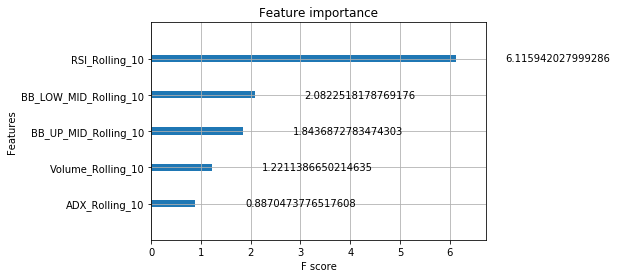

In [114]:
# Let's see which factors wheremost significant for predicting the labels
xgb.plot_importance(myxgb,importance_type = "gain")

# Above figure shows that RSI was much more reliable indicator to predict short-medium term reversals (within 10 days)
# Bollinger bands too provide predictability to an extent, but they are limited to short term volatilities. 

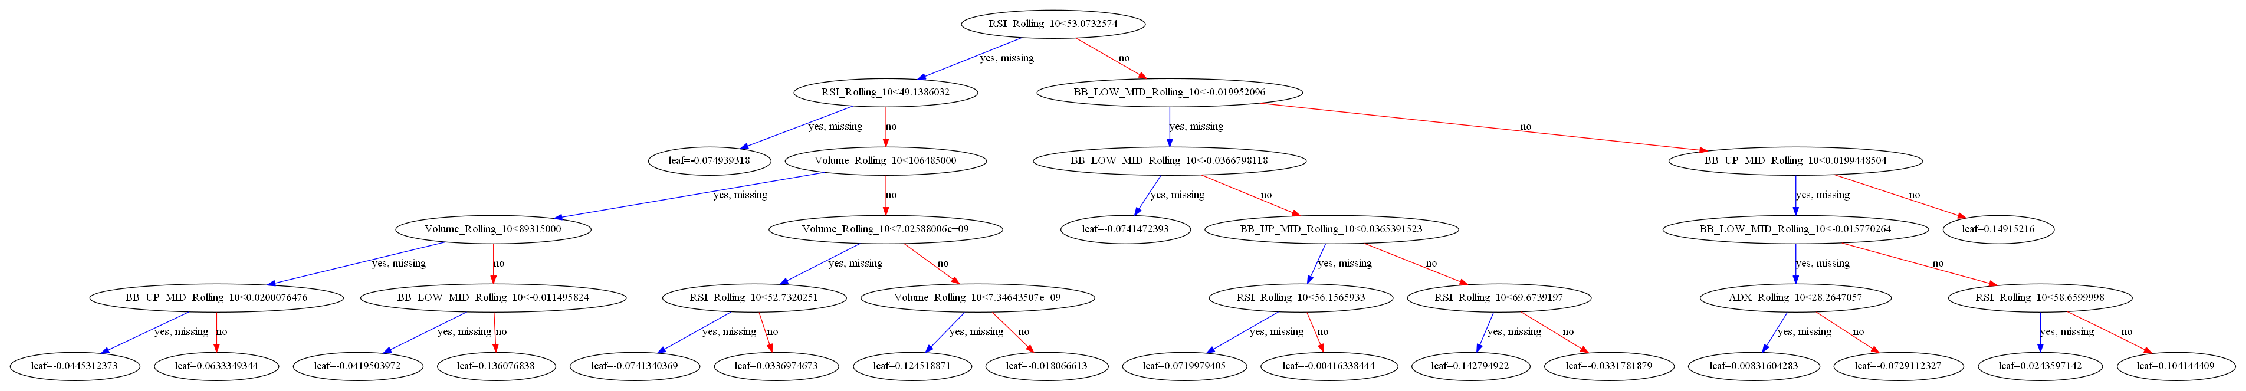

In [119]:
# Unfortunately, XGBoost doesn't provides sure shot thresholds which 
#can lead to respective leavesas is consists of multiple estimators.

# Plot graph #Optional

import graphviz

from matplotlib import pyplot 

xgb.plot_tree(myxgb, num_trees=0)
fig = pyplot.gcf()
fig.set_size_inches(40,800)
